In [221]:
import train_cnn
import stacked_ae
import utils
import matplotlib.pyplot as plt 
import numpy as np
import imp
imp.reload(train_cnn)
imp.reload(utils)
imp.reload(stacked_ae)
%matplotlib inline
import pandas as pd

# Test for CNN

## Trainset

`models_cnn = {model type : [X, X_fullsize, Y, contour_mask, y_pred, history, model]}`  
Training CNN --> it took 2min (simple), 5min (2 convs)

In [76]:
variants = ['simple', 'larger', 'deeper', 'maxpooling']
models_cnn = {k:train_cnn.run(model=k, history=True) for k in variants}
models_cnn['relu'] = train_cnn.run(model='simple', history=True, activation='relu')

Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)
Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)
Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)
Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)
Dataset shape : (495, 64, 64, 1) (495, 1, 32, 32)


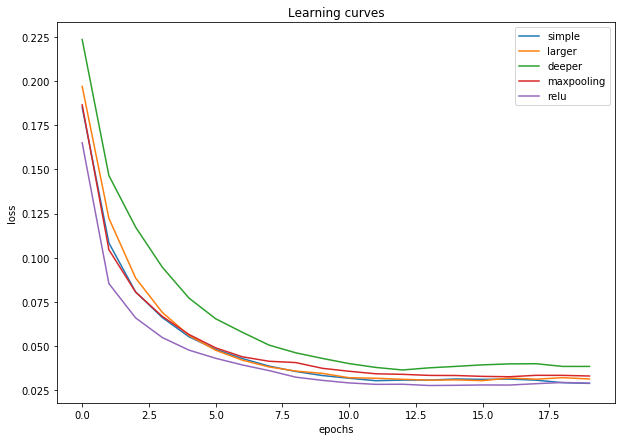

In [79]:
plt.figure(figsize=(10,7))
for k, v in models_cnn.items():
    it = range(len(v[5].history[metric]))
    plt.plot(it, v[5].history['loss'], label=k)
plt.ylabel(metric)
plt.xlabel('epochs')
plt.title("Learning curves")
plt.legend()

`models_stackedae = {model type : [X, Y, binarys, model]}`  
Training stacked AE --> it took 23s

In [80]:
models_stackedae = {k:stacked_ae.run(v[1], v[4], v[3]) for k,v in models_cnn.items()}

`metrics = {model type : [dice metric, conformity coefficient]}`  

In [81]:
metrics = {k:stats_results(v[1], v[2]) for k,v in models_stackedae.items()}

In [113]:
for k, v in metrics.items():
    print('%s - DM :%.1f%%, CC :%.1f, Top 5 :' % (k, 100*v[0].mean(), v[1].mean()), 
         list(zip(sorted(map(lambda x:'%.2f' % x, v[0]), reverse=True)[:5], v[0].argsort()[::-1][:5])))

simple - DM :0.37%, CC :-15.7, Top 5 : [('0.84', 410), ('0.84', 418), ('0.84', 391), ('0.84', 388), ('0.81', 322)]
larger - DM :0.36%, CC :-18.1, Top 5 : [('0.85', 233), ('0.85', 224), ('0.85', 466), ('0.85', 469), ('0.83', 464)]
deeper - DM :0.39%, CC :-15.4, Top 5 : [('0.93', 275), ('0.93', 285), ('0.90', 45), ('0.90', 51), ('0.90', 481)]
maxpooling - DM :0.39%, CC :-13.0, Top 5 : [('0.93', 424), ('0.93', 406), ('0.92', 289), ('0.91', 94), ('0.91', 96)]
relu - DM :0.41%, CC :-13.8, Top 5 : [('0.91', 211), ('0.91', 212), ('0.91', 220), ('0.91', 236), ('0.90', 214)]


In [137]:
# Find the index that maximizes all models
dm = {k:v[0] for k,v in metrics.items()}
df = pd.DataFrame(dm)
df[df>0.6].dropna(how='any').sort_values('larger', ascending=False).head(10)

,deeper,larger,maxpooling,relu,simple
439,0.652424,0.821918,0.705010,0.647251,0.700455
428,0.652424,0.821918,0.705010,0.647251,0.700455
460,0.647059,0.805677,0.883983,0.644723,0.644578
441,0.647059,0.805677,0.883983,0.644723,0.644578
433,0.647059,0.805677,0.883983,0.644723,0.644578
432,0.647059,0.805677,0.883983,0.644723,0.644578
221,0.759494,0.798122,0.759102,0.842817,0.759713
223,0.759494,0.798122,0.759102,0.842817,0.759713
230,0.759494,0.798122,0.759102,0.842817,0.759713
235,0.759494,0.798122,0.759102,0.842817,0.759713


Text(0.5,1,'Ground Truth')

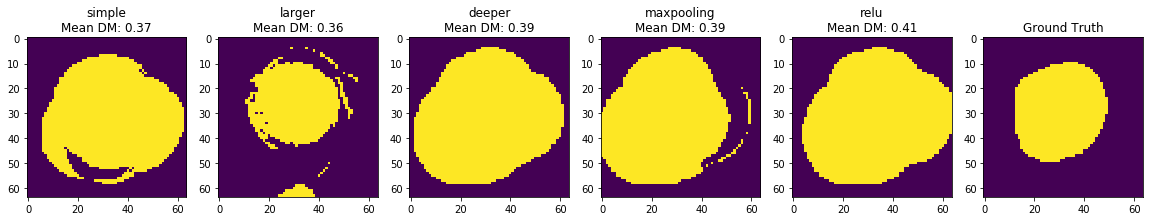

In [138]:
idx = 439
f, ax = plt.subplots(ncols=len(metrics)+1, figsize=(20,5))
for i, (model, v) in enumerate(models_stackedae.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean DM: %.2f' % (model, metrics[model][0].mean()))
ax[5].imshow(v[1][idx].reshape((64,64)))
ax[5].set_title('Ground Truth')

**To do for Test**  
1. Il faut créer des nouvelles fonctions pour le test genre par exemple une autre fonction de model dans le CNN qui integrerait une nouvelle couche de convolution, ou qui soit avec des Relus, ou des filtres de tailles différentes, etc. et idem pour le stacked AE : changer les inits, change la taille de 100x100 par autres choses et faire que ses fonctions soient justes des options des .run() au dessus
2.  Tester sur le test set ! 

## Test set

`inference_cnn = {model type : [X_test, X_fullsize_test, Y_test, contour_mask_test, y_pred_test]}`  
Inference CNN --> it took 24s

In [139]:
inference_cnn = {k:train_cnn.inference(v[6]) for k,v in models_cnn.items()}

Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)
Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)
Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)
Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)
Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)


`inference_sae = {model type : [X_, Y_, binarys_test]}`  
Inference Stacked AE --> it took 0.4s

In [142]:
inference_sae = {k:stacked_ae.inference(v[1], v[4], v[3], models_stackedae[k][3]) for k,v in inference_cnn.items()}

`metrics_test = {model type : [dice metric, conformity coefficient]}`  

In [143]:
metrics_test = {k:stats_results(v[1], v[2]) for k,v in inference_sae.items()}

In [162]:
print('model - DM: Test (Train), CC: Test (Train)')
for (k, v), (k1,v1) in zip(metrics_test.items(),metrics.items()):
    print('%s - DM: %.1f%% (%.1f%%), CC: %.1f (%.1f)' % (k, 100*v[0].mean(), 100*v1[0].mean(), 
                                                     v[1].mean(), v1[1].mean()))

model - DM: Test (Train), CC: Test (Train)
simple - DM: 35.6% (36.6%), CC: -14.6 (-15.7)
larger - DM: 22.1% (35.9%), CC: -25.8 (-18.1)
deeper - DM: 31.4% (39.0%), CC: -22.1 (-15.4)
maxpooling - DM: 35.5% (38.6%), CC: -32.4 (-13.0)
relu - DM: 36.2% (41.5%), CC: -11.1 (-13.8)


In [190]:
# Find the index that maximizes all models
dm = {k:v[0] for k,v in metrics_test.items()}
cc = {k:v[1] for k,v in metrics_test.items()}
df = pd.DataFrame(dm)
df[df>0.6].dropna(how='any').sort_values('deeper', ascending=False).head(10)

,deeper,larger,maxpooling,relu,simple
416,0.815589,0.706390,0.814604,0.798952,0.805844
418,0.815589,0.706390,0.814604,0.798952,0.805844
444,0.815589,0.706390,0.814604,0.798952,0.805844
415,0.713466,0.625354,0.848598,0.708420,0.793227
419,0.713466,0.625354,0.848598,0.708420,0.793227
439,0.713466,0.625354,0.848598,0.708420,0.793227
236,0.701818,0.698468,0.697740,0.928177,0.753623
253,0.701818,0.698468,0.697740,0.928177,0.753623
238,0.677471,0.671406,0.674283,0.750123,0.675476
246,0.677471,0.671406,0.674283,0.750123,0.675476


Text(0.5,1,'Ground Truth')

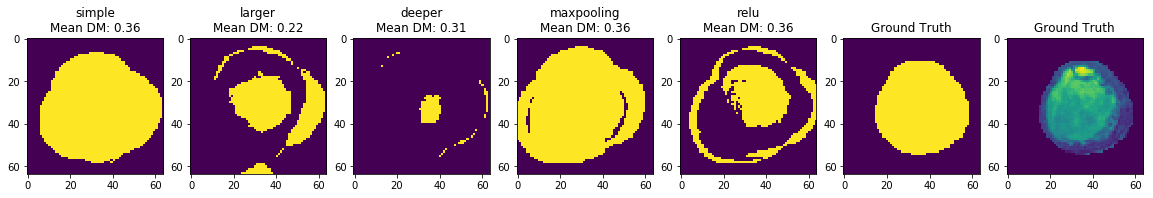

In [197]:
idx = 383
f, ax = plt.subplots(ncols=len(metrics_test)+2, figsize=(20,5))
for i, (model, v) in enumerate(inference_sae.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean DM: %.2f' % (model, metrics_test[model][0].mean()))
#     cv2.imwrite('./Rapport/images/results_%s_img%s.png' % (model,idx), v[2][idx])
ax[5].imshow(v[1][idx].reshape((64,64)))
ax[5].set_title('Ground Truth')

ax[6].imshow(v[1][idx].reshape((64,64))*v[0][idx].reshape((64,64)))
ax[6].set_title('Ground Truth')

# Tests for Stacked AE

## Train set

In [220]:
try:
    _, X_fullsize, _, contour_mask, y_pred, h, m = models_cnn['simple']
except:
    _, X_fullsize, _, contour_mask, y_pred, h, m = train_cnn.run(model='simple', history=True)

`models_sae_init = {init type : [X, Y, binarys, model, history]}`   

In [222]:
inits = ['zero', 'random_uniform', 'random_normal']
models_sae_init = {k:stacked_ae.run(X_fullsize, y_pred, contour_mask, init_3=k, history=True) for k in inits}

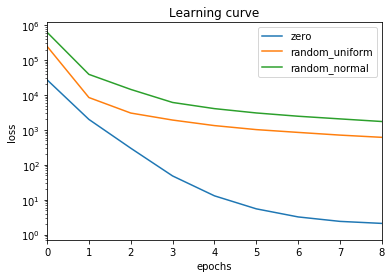

In [229]:
for k, v in models_sae_init.items():
    it = range(len(v[4]))
    plt.plot(it, v[4], label=k)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curve")
plt.legend()
plt.xlim([0,8])
plt.yscale("log", nonposy='clip')

`models_sae_loss = {loss type : [X, Y, binarys, model, history]}`   

In [235]:
loss = ["customized_loss", "MSE", "kullback_leibler_divergence"]
models_sae_loss = {'%s + MSE' % l :stacked_ae.run(X_fullsize, y_pred, contour_mask, history=True, 
                            loss1=l, loss2=l, loss3="MSE") for l in loss}

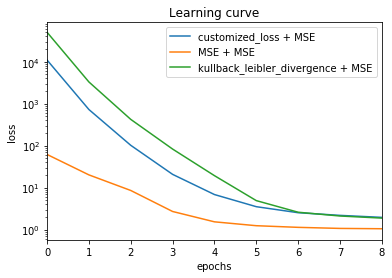

In [237]:
for k, v in models_sae_loss.items():
    it = range(len(v[4]))
    plt.plot(it, v[4], label=k)
plt.ylabel('loss')
plt.xlabel('epochs')
plt.title("Learning curve")
plt.legend()
plt.xlim([0,8])
plt.yscale("log", nonposy='clip')

`metrics = {loss type : [dice metric, conformity coefficient]}`  

In [246]:
metrics_sae_loss = {k:stats_results(v[1], v[2]) for k, v in models_sae_loss.items()}

In [239]:
for k, v in metrics_sae_loss.items():
    print('%s - DM :%.1f%%, CC :%.1f' % (k, 100*v[0].mean(), v[1].mean()))

customized_loss + MSE - DM :36.9%, CC :-14.0
MSE + MSE - DM :49.5%, CC :-11.0
kullback_leibler_divergence + MSE - DM :37.9%, CC :-19.6


Text(0.5,1,'Ground Truth')

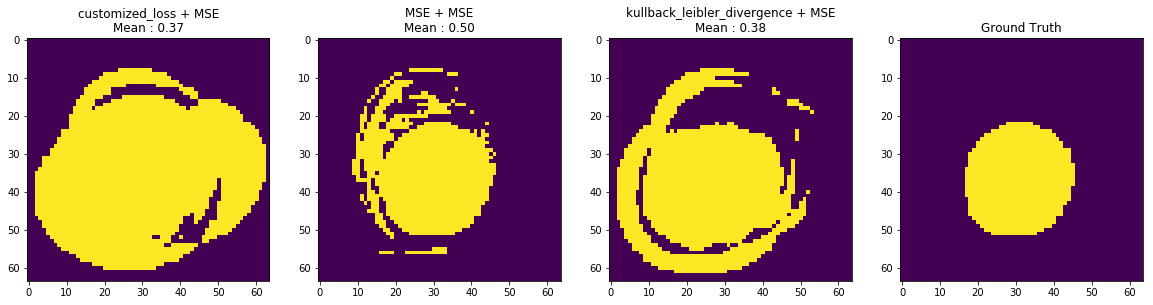

In [242]:
idx = 47
f, ax = plt.subplots(ncols=len(metrics_sae_loss)+1, figsize=(20,5))
for i, (model, v) in enumerate(models_sae_loss.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean : %.2f' % (model, metrics_sae_loss[model][0].mean()))
ax[3].imshow(v[1][idx].reshape((64,64)))
ax[3].set_title('Ground Truth')

## Test set

In [243]:
X_test, X_fullsize_test, Y_test, contour_mask_test, y_pred = train_cnn.inference(models_cnn['simple'][6])

Dataset shape : (524, 64, 64, 1) (524, 1, 32, 32)


In [244]:
inference_sae_loss = {k:stacked_ae.inference(X_fullsize_test, y_pred, contour_mask_test, v[3]) 
                          for k,v in models_sae_loss.items()}

In [247]:
metrics_sae_loss_inf = {k:stats_results(v[1], v[2]) for k, v in inference_sae_loss.items()}

In [248]:
print('model - DM: Test (Train), CC: Test (Train)')
for (k, v), (k1,v1) in zip(metrics_sae_loss_inf.items(),metrics_sae_loss.items()):
    print('%s - DM: %.1f%% (%.1f%%), CC: %.1f (%.1f)' % (k, 100*v[0].mean(), 100*v1[0].mean(), 
                                                     v[1].mean(), v1[1].mean()))

model - DM: Test (Train), CC: Test (Train)
customized_loss + MSE - DM: 28.3% (36.9%), CC: -12.6 (-14.0)
MSE + MSE - DM: 43.6% (49.5%), CC: -12.0 (-11.0)
kullback_leibler_divergence + MSE - DM: 38.2% (37.9%), CC: -19.5 (-19.6)


Text(0.5,1,'Ground Truth')

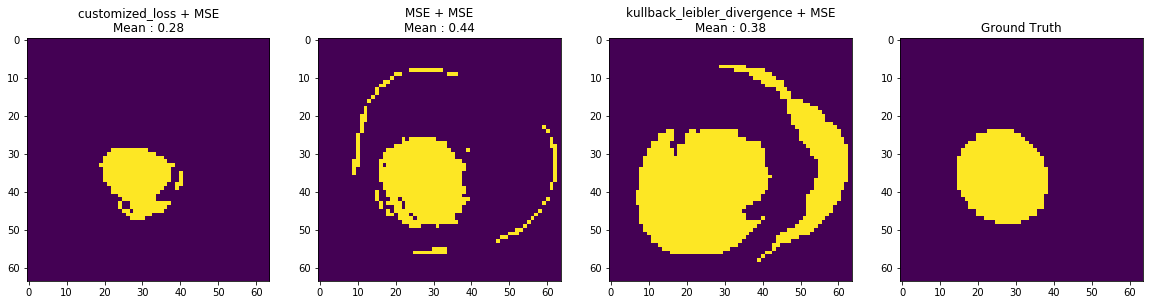

In [249]:
idx = 47
f, ax = plt.subplots(ncols=len(metrics_sae_loss_inf)+1, figsize=(20,5))
for i, (model, v) in enumerate(inference_sae_loss.items()):
    ax[i].imshow(v[2][idx])
    ax[i].set_title('%s\nMean : %.2f' % (model, metrics_sae_loss_inf[model][0].mean()))
ax[3].imshow(v[1][idx].reshape((64,64)))
ax[3].set_title('Ground Truth')